#**Description of Notebook:**
The following notebook trains each model on the independently sourced training and validation **LMPred dataset**, according to the best hyperparameters during tuning. The best models (according to lowest validation loss during training) were saved and the validation accuracy/loss curves are plotted along with any reductions in learning rate during training.

#**Imports:**

In [ ]:
import os
import re
import json
import string
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten, Dropout, InputLayer, Conv2D, MaxPooling2D, BatchNormalization, Input
import pandas as pd
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.ticker as mtick
from matplotlib import pyplot as plt

In [ ]:
print('Mounting google drive...')
from google.colab import drive
drive.mount('/content/drive')
%cd "INSERT_GOOGLE_DRIVE_LOC"

#**Loading Data:**

In [ ]:
# Target Data:
y_train = np.array(pd.read_csv('LM_Pred_Dataset/y_train.csv', header=None))
y_val = np.array(pd.read_csv('LM_Pred_Dataset/y_val.csv', header=None))
y_test = np.array(pd.read_csv('LM_Pred_Dataset/y_test.csv', header=None))

In [ ]:
# Reshaping y Data:
y_train_res = y_train.astype('float32').reshape((-1,1))
y_val_res = y_val.astype('float32').reshape((-1,1))

In [ ]:
def load_X_data(lang_model):
  if lang_model =='BERT':
    X_train = np.load('Embeddings/BERT/BERT_INDEP_X_TRAIN.npy')
    X_val = np.load('Embeddings/BERT/BERT_INDEP_X_VAL.npy')
  elif lang_model =='BERT_BFD':
    X_train = np.load('Embeddings/BERT_BFD/BERT_BFD_INDEP_X_TRAIN.npy')
    X_val = np.load('Embeddings/BERT_BFD/BERT_BFD_INDEP_X_VAL.npy')
  elif lang_model =='T5XL_UNI':
    X_train = np.load('Embeddings/T5XL_UNI/T5XL_UNI_INDEP_X_TRAIN.npy')
    X_val = np.load('Embeddings/T5XL_UNI/T5XL_UNI_INDEP_X_VAL.npy')
  elif lang_model =='T5XL_BFD':
    X_train = np.load('Embeddings/T5XL_BFD/T5XL_BFD_INDEP_X_TRAIN.npy')
    X_val = np.load('Embeddings/T5XL_BFD/T5XL_BFD_INDEP_X_VAL.npy')
  elif lang_model =='XLNET':
    X_train = np.load('Embeddings/XLNET/XLNET_INDEP_X_TRAIN.npy')
    X_val = np.load('Embeddings/XLNET/XLNET_INDEP_X_VAL.npy')

  return X_train, X_val

#**Model Creation:**

##**One Layer Model:**

In [ ]:
def train_model(X_train, y_train, X_val, y_val, model_path, plots_path, epochs, batch_size, use_tpu, filter, k_size, k_init, pool_strides, lr, opt):

    def create_model():
      # Create model
      model = Sequential()

      # Adding Convolutional (2D) Layer:
      model.add(Conv2D(filters=filter, kernel_size=k_size, activation='relu', 
                      strides = 1, kernel_initializer=k_init, padding='same',
                      input_shape = (255, 1024, 1)))

      # Adding Max Pooling Layer:
      model.add(MaxPooling2D(pool_size=2, strides=pool_strides))

      # Adding Batch Normalisation Layer:
      model.add(BatchNormalization(axis=1, momentum=0.99, epsilon=0.001))

      model.add(Flatten())

      # Adding the dense layer using Sigmoid function to predict in range [0, 1]:
      model.add(Dense(1, activation='sigmoid'))
      
      # Choosing optimizer and compiling model:
      if opt == 'Adam':
        optimizer = keras.optimizers.Adam(learning_rate=lr)
      else:
        optimizer = keras.optimizers.SGD(learning_rate=lr)

      model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

      return model

    # Assigning to TPU strategy:
    # Disabling displayed debugging logs:
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    if use_tpu:
        # Create distribution strategy:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)

        # Create model:
        with strategy.scope():
            model = create_model()
    else:
        !nvidia-smi -L
        model = create_model()

    model.summary()

    # Using callbacks for the model:
    earlyStopping = EarlyStopping(monitor='val_loss', patience=12, verbose=0, mode='min')
    mcp_save = ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss', mode='min')
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_delta=1e-4, mode='min')

    # Reshaping X and y Data for Model Input:
    seq_height = 255
    seq_width = 1024

    X_train_res = X_train.reshape(X_train.shape[0], seq_height, seq_width, 1)
    X_val_res = X_val.reshape(X_val.shape[0], seq_height, seq_width, 1)

    y_train_res = y_train.astype('float32').reshape((-1,1))
    y_val_res = y_val.astype('float32').reshape((-1,1))


    # Fitting the model:
    history = model.fit(X_train_res,
              y_train_res,
              validation_data=(X_val_res, y_val_res),
              epochs=epochs,
              batch_size=batch_size,
              callbacks=[earlyStopping, mcp_save, reduce_lr_loss])
    
    # Plotting Accuracy and Loss Curves:
    fig, ax = plt.subplots(1,2, figsize=(18,6), dpi=80)
    train_metrics = ['accuracy', 'loss']
    val_metrics = ['val_accuracy', 'val_loss']
    titles = ['Model Accuracy', 'Model Loss vs. Learning Rate']
    y_labels = ['Accuracy', 'Loss']
    leg_loc = ['upper left', 'upper right']

    for i in range(2):
      
      ax[i].plot(history.history[train_metrics[i]])
      ax[i].plot(history.history[val_metrics[i]])
      
      if i == 1:
        ax2=ax[i].twinx()
        ax2.plot(history.history['lr'], color= 'magenta', linestyle='dotted')
        ax2.set_ylabel('Learning Rate')
        ax2.legend(['Learning Rate'], fancybox=True, framealpha=1, shadow=True, borderpad=1, bbox_to_anchor=(1.0, 0.85))
        ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.e'))

      
      ax[i].set_title(titles[i], fontsize=12, fontweight='bold')
      ax[i].set_ylabel(y_labels[i])
      ax[i].set_xlabel('Epoch')
      ax[i].legend(['Train', 'Val'], loc=leg_loc[i], fancybox=True, framealpha=1, shadow=True, borderpad=1)

    plt.savefig(plots_path, bbox_inches='tight')
    plt.show()
    

##**Two Layer Model:**

In [ ]:
def train_complex_model(X_train, y_train, X_val, y_val, model_path, plots_path, epochs, batch_size, use_tpu, filter, k_size, k_init, pool, pool_strides, filter2, k_size2, pool2, p_strides2, dense1, dense2, dropout, lr, opt):

    def create_model():
      # Create model
      model = Sequential()

      # Adding Convolutional (2D) Layer:
      model.add(Conv2D(filters=filter, kernel_size=k_size, activation='relu', 
                      strides = 1, kernel_initializer=k_init, padding='same',
                      input_shape = (255, 1024, 1)))

      # Adding Max Pooling Layer:
      model.add(MaxPooling2D(pool_size=pool, strides=pool_strides))

      # Adding Batch Normalisation Layer:
      model.add(BatchNormalization(axis=1, momentum=0.99, epsilon=0.001))

      # Adding Convolutional (2D) Layer:
      model.add(Conv2D(filters=filter2, kernel_size=k_size2, activation='relu', 
                      strides = 1, kernel_initializer=k_init, padding='same',
                      input_shape = (255, 1024, 1)))

      # Adding Max Pooling Layer:
      model.add(MaxPooling2D(pool_size=pool2, strides=p_strides2))
      
      # Adding Batch Normalisation Layer:
      model.add(BatchNormalization(axis=1, momentum=0.99, epsilon=0.001))

      model.add(Flatten())

      model.add(Dense(dense1, activation='relu'))
      model.add(Dropout(rate=dropout))

      model.add(Dense(dense2, activation='relu'))
      model.add(Dropout(rate=dropout))

      # Adding the dense layer using Sigmoid function to predict in range [0, 1]:
      model.add(Dense(1, activation='sigmoid'))
      
      # Choosing optimizer and compiling model:
      if opt == 'Adam':
        optimizer = keras.optimizers.Adam(learning_rate=lr)
      else:
        optimizer = keras.optimizers.SGD(learning_rate=lr)
        
      model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

      return model

    # Assigning to TPU strategy:
    # Disabling displayed debugging logs:
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    if use_tpu:
        # Create distribution strategy:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)

        # Create model:
        with strategy.scope():
            model = create_model()
    else:
        !nvidia-smi -L
        model = create_model()

    model.summary()

    # Using callbacks for the model:
    earlyStopping = EarlyStopping(monitor='val_loss', patience=12, verbose=0, mode='min')
    mcp_save = ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss', mode='min')
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4, mode='min')

    # Reshaping X and y Data for Model Input:
    seq_height = 255
    seq_width = 1024

    X_train_res = X_train.reshape(X_train.shape[0], seq_height, seq_width, 1)
    X_val_res = X_val.reshape(X_val.shape[0], seq_height, seq_width, 1)

    y_train_res = y_train.astype('float32').reshape((-1,1))
    y_val_res = y_val.astype('float32').reshape((-1,1))


    # Fitting the model:
    history = model.fit(X_train_res,
              y_train_res,
              validation_data=(X_val_res, y_val_res),
              epochs=epochs,
              batch_size=batch_size,
              callbacks=[earlyStopping, mcp_save, reduce_lr_loss])
    
    # Plotting Accuracy and Loss Curves:
    fig, ax = plt.subplots(1,2, figsize=(18,6), dpi=80)
    train_metrics = ['accuracy', 'loss']
    val_metrics = ['val_accuracy', 'val_loss']
    titles = ['Model Accuracy', 'Model Loss vs. Learning Rate']
    y_labels = ['Accuracy', 'Loss']
    leg_loc = ['upper left', 'upper right']

    for i in range(2):
      
      ax[i].plot(history.history[train_metrics[i]])
      ax[i].plot(history.history[val_metrics[i]])
      
      if i == 1:
        ax2=ax[i].twinx()
        ax2.plot(history.history['lr'], color= 'magenta', linestyle='dotted')
        ax2.set_ylabel('Learning Rate')
        ax2.legend(['Learning Rate'], fancybox=True, framealpha=1, shadow=True, borderpad=1, bbox_to_anchor=(1.0, 0.85))
        ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.e'))

      
      ax[i].set_title(titles[i], fontsize=12, fontweight='bold')
      ax[i].set_ylabel(y_labels[i])
      ax[i].set_xlabel('Epoch')
      ax[i].legend(['Train', 'Val'], loc=leg_loc[i], fancybox=True, framealpha=1, shadow=True, borderpad=1)

    plt.savefig(plots_path, bbox_inches='tight')
    plt.show()
    

#**Model Training:**

##**BERT:**

In [ ]:
X_train, X_val = load_X_data('BERT')

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-52a51320-971d-dcb8-6340-bcb3526c91ce)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 255, 1024, 320)    39040     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 128, 320)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 128, 320)      128       
_________________________________________________________________
flatten (Flatten)            (None, 1310720)           0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1310721   
Total params: 1,349,889
Trainable params: 1,349,825
Non-trainable params: 64
_________________________________________________________________
Epoch 1/30
376/376 [==============

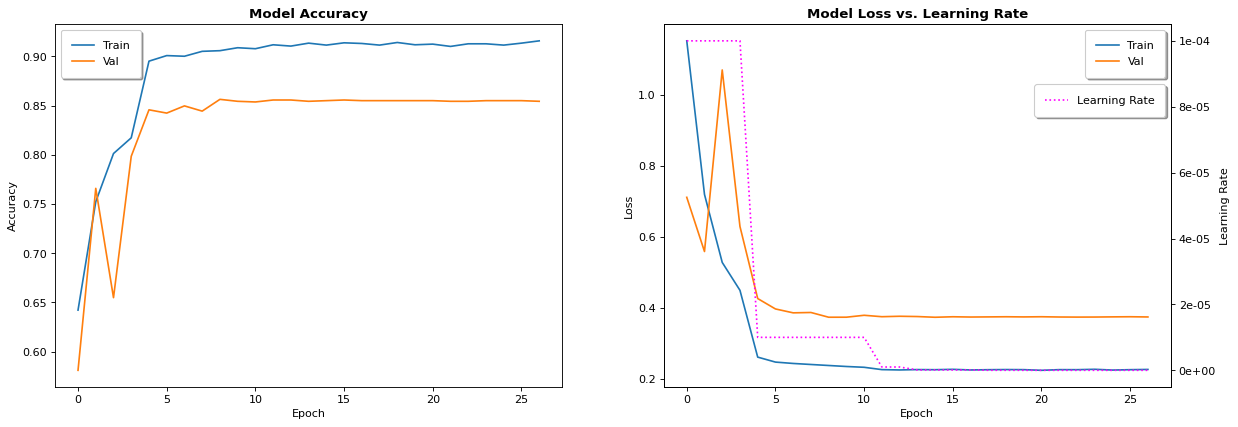

In [ ]:
BERT_filepath = 'Keras_Models/BERT_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
BERT_Plots_Path = 'Training_Plots/INDEP/BERT_Best_Model_Plot.png'
train_model(X_train, y_train_res, X_val, y_val_res, BERT_filepath, BERT_Plots_Path, 30, 8, False, 320, 11, 'RandomNormal', 8, 0.0001, 'SGD')

##**BERT BFD:**

In [ ]:
X_train, X_val = load_X_data('BERT_BFD')

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-52a51320-971d-dcb8-6340-bcb3526c91ce)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 255, 1024, 320)    39040     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 128, 320)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 128, 320)      128       
_________________________________________________________________
flatten (Flatten)            (None, 1310720)           0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1310721   
Total params: 1,349,889
Trainable params: 1,349,825
Non-trainable params: 64
_________________________________________________________________
Epoch 1/30
376/376 [==============

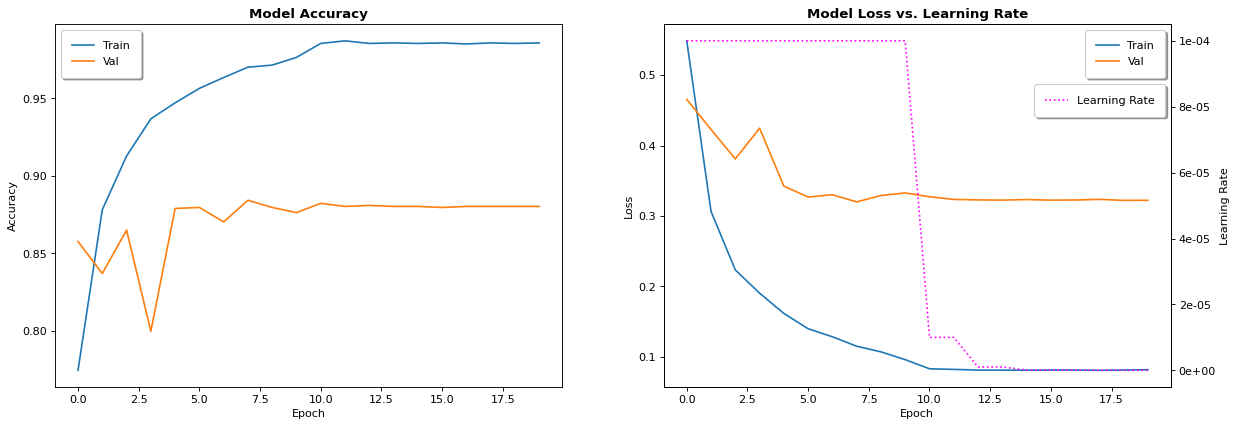

In [ ]:
BERT_BFD_filepath = 'Keras_Models/BERT_BFD_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
BERT_BFD_Plots_Path = 'Training_Plots/INDEP/BERT_BFD_Best_Model_Plot.png'
train_model(X_train, y_train_res, X_val, y_val_res, BERT_BFD_filepath, BERT_BFD_Plots_Path, 30, 8, False, 320, 11, 'RandomNormal', 8, 0.0001, 'SGD')

##**T5XL_UNI:**

In [ ]:
X_train, X_val = load_X_data('T5XL_UNI')

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-2bcccdb2-75bf-3509-d313-72a6ec56e72e)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 255, 1024, 352)    256960    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 256, 352)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 256, 352)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 256, 128)      19869824  
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 64, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 64, 128)       64        
_____________________________________________

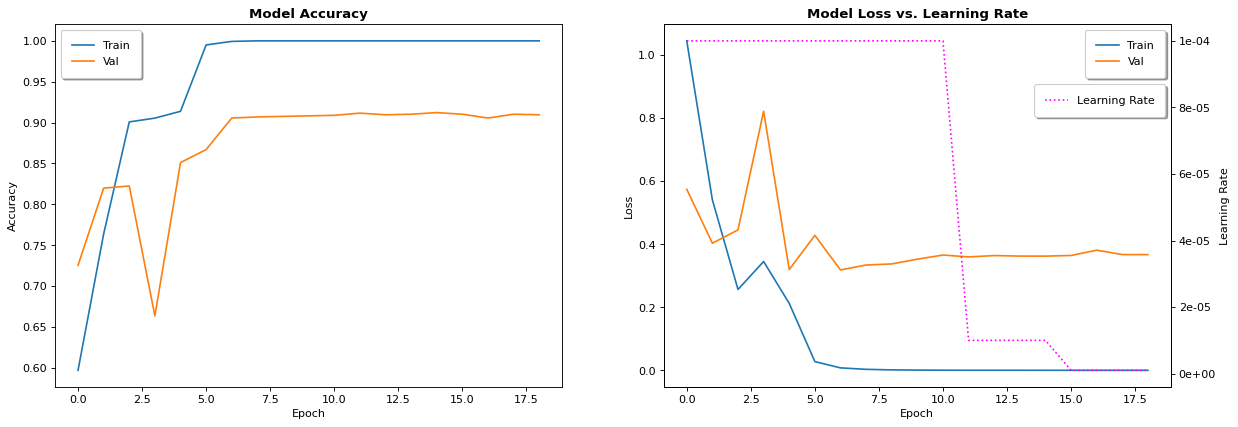

In [ ]:
filepath = 'Keras_Models/T5XL_UNI_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
Plots_Path = 'Training_Plots/INDEP/T5XL_UNI_best_model_plot2.png'
train_complex_model(X_train, y_train_res, X_val, y_val_res, filepath, Plots_Path, 30, 8, False, 352, 27, 'RandomNormal', 2, 4, 128, 21, 2, 4, 640, 64, 0.0, 0.0001, 'Adam')

##**T5XL_BFD:**

In [ ]:
X_train, X_val = load_X_data('T5XL_BFD')

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-7bf31444-b3e9-de40-91c0-e571b05336bb)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 255, 1024, 384)    240384    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 128, 384)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 128, 384)      128       
_________________________________________________________________
flatten (Flatten)            (None, 1572864)           0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1572865   
Total params: 1,813,377
Trainable params: 1,813,313
Non-trainable params: 64
_________________________________________________________________
Epoch 1/30
376/376 [==============

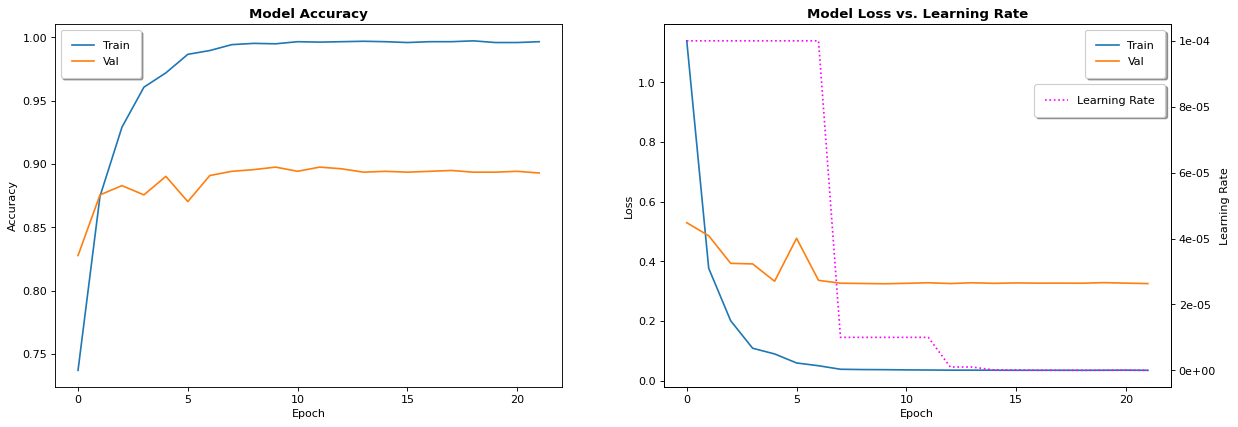

In [ ]:
filepath = 'Keras_Models/T5XL_BFD_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
Plots_Path = 'Training_Plots/INDEP/T5XL_BFD_best_model_plot.png'
train_model(X_train, y_train_res, X_val, y_val_res, filepath, Plots_Path, 30, 8, False, 384, 25, 'RandomNormal', 8, 0.0001, 'SGD')

##**XLNET:**

In [ ]:
X_train, X_val = load_X_data('XLNET')

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-35d64320-d33a-929a-2b0b-16885d22268f)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 255, 1024, 352)    296384    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 85, 352)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 21, 85, 352)       84        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 85, 64)        8132672   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 11, 64)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 11, 64)         12        
_____________________________________________

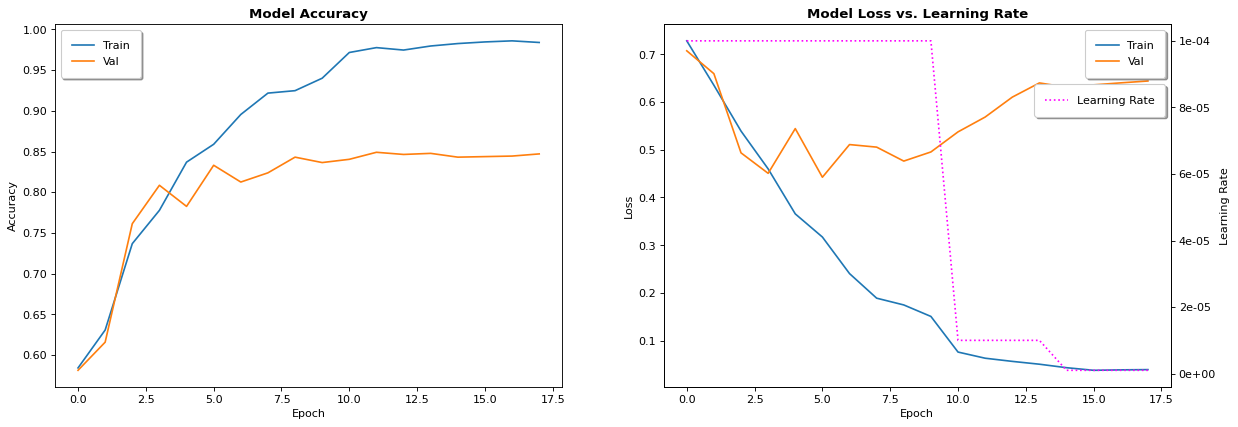

In [ ]:
filepath = 'Keras_Models/XLNET_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
Plots_Path = 'Training_Plots/INDEP/XLNET_best_model_plot.png'
train_complex_model(X_train, y_train_res, X_val, y_val_res, filepath, Plots_Path, 30, 8, False, 352, 29, 'RandomNormal', 6, 12, 64, 19, 2, 8, 1024, 64, 0.2, 0.0001, 'Adam')